In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("Melvinjj/bert_results")

C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kevin\.cache\huggingface\hub\models--Melvinjj--bert_results. Ca

In [2]:
import os
import shutil

import pandas as pd
import tensorflow as tf
import torch
import numpy as np

In [3]:
df = pd.read_csv("./football_events.csv")

In [4]:
event_labels = {
    'free kick': 0,
    'foul': 1,
    'attempt': 2,
    'corner': 3,
    'substitution': 4,
    'offside': 5,
    'yellow card': 6,
    'handball': 7,
    'penalty': 8,
    'red card': 9
}
df['event_label'] = df['event'].map(event_labels)

In [5]:
df_train = df[["Text", "event_label"]]

In [6]:
df_train, df_val, df_test = np.split(df_train.sample(frac=1, random_state=42), [int(.8*len(df_train)), int(.9*len(df_train))])

C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
from datasets import Dataset

df_train["label"] = df_train["event_label"]
train_dataset = Dataset.from_pandas(df_train[["Text","label"]])

df_test["label"] = df_test["event_label"]
test_dataset = Dataset.from_pandas(df_test[["Text","label"]])

In [8]:
test_dataset = test_dataset.remove_columns('__index_level_0__')

In [9]:
test_dataset = test_dataset.map(lambda e: tokenizer(e["Text"], padding='max_length', truncation=True), batched=True)

Map: 100%|██████████████████████████████████████████████████████████████| 94101/94101 [00:15<00:00, 6071.07 examples/s]


In [11]:
import evaluate

# Load the accuracy metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [12]:
from transformers import Trainer, TrainingArguments

# Load the model
model = AutoModelForSequenceClassification.from_pretrained("Melvinjj/bert_results")
training_args = TrainingArguments(
    output_dir="./bert_results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
)
# Update the trainer to use the newly loaded model
trainer = Trainer(
    model=model,                 # Use the loaded model
    args=training_args,          # Training arguments
    train_dataset=train_dataset,  # Training dataset
    eval_dataset=test_dataset,    # Evaluation dataset
    compute_metrics=compute_metrics  # Metrics function if defined
)

In [13]:
pred = trainer.predict(test_dataset)

C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming `pred` is the prediction output from `trainer.predict(test_dataset)`
pred_labels = np.argmax(pred.predictions, axis=1)
true_labels = pred.label_ids

# Reverse the dictionary to decode labels back to event names
label_decoder = {v: k for k, v in event_labels.items()}
decoded_predictions = [label_decoder[label] for label in pred_labels]
decoded_true_labels = [label_decoder[label] for label in true_labels]

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


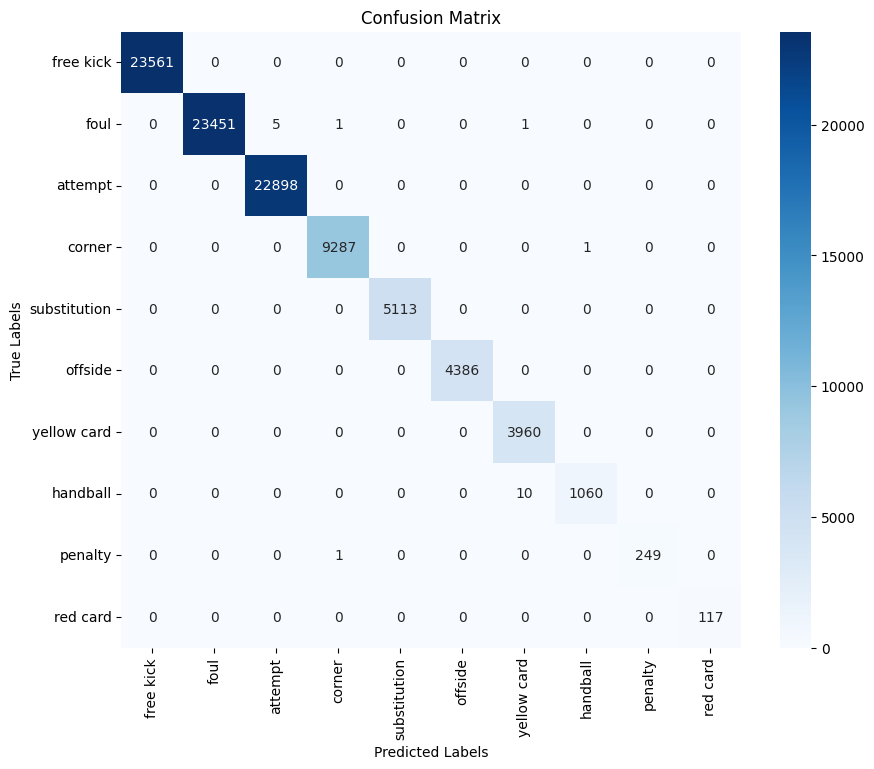

In [15]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(event_labels.keys()),
            yticklabels=list(event_labels.keys()))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()